In [7]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import random
import matplotlib.pylab as plt
import sklearn
import keras
from matplotlib.image import imread
import cv2
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, Conv1D, MaxPool2D, MaxPooling2D
%matplotlib inline

In [3]:
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x1851_y1251_class1.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x1451_y1551_class1.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x1101_y1301_class1.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x1301_y1251_class1.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x1651_y1101_class1.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x2051_y1401_class1.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x2051_y2401_class1.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x1601_y1751_class1.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x1751_y1251_class1.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/12935/1/12935_idx5_x20

Color Image Shape: (50, 50, 3)


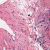

In [13]:
test_img = load_img('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png')
print(f"Color Image Shape: {(img_to_array(test_img)).shape}")
test_img

Grayscaled Image Shape: (50, 50, 1)


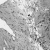

In [14]:
test_img = load_img('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', color_mode = "grayscale")
print(f"Grayscaled Image Shape: {(img_to_array(test_img)).shape}")
test_img

In [15]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [16]:
sampled_class0 = random.sample(class0, 30000)
sampled_class1 = random.sample(class1, 30000)
len(sampled_class0)

30000

In [17]:
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
      if i.endswith('.png'):
        img = cv2.imread(i ,cv2.IMREAD_GRAYSCALE)
        img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
        img_arrays.append([img_sized, label])
    return img_arrays

In [ ]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [ ]:
test = cv2.imread('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_GRAYSCALE)
test.shape

In [ ]:
combined_data = np.concatenate((class0_array, class1_array))
random.seed(42)
random.shuffle(combined_data)

In [ ]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [ ]:
# reshape X data
X = np.array(X).reshape(-1, 50, 50)
X.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
#create model
model_grayscale = Sequential()

#add model layers
model_grayscale.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(50,50)))
model_grayscale.add(Conv1D(32, kernel_size=3, activation='relu'))
model_grayscale.add(Conv1D(8, kernel_size=3, activation='relu'))

model_grayscale.add(Flatten())
model_grayscale.add(Dense(2, activation='softmax'))

In [ ]:
model_grayscale.summary()

In [ ]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_grayscale.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_grayscale.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

In [ ]:
model_loss, model_accuracy = model_grayscale.evaluate(
    X_test, y_test, verbose=3)
print(f"Neural Network\n- Accuracy: {(model_accuracy*100):2f}%\n- Loss: {model_loss}")

In [ ]:
# save the best model
import joblib
filename = 'cancer_grayscale_ML_model.h5'
joblib.dump(model_grayscale, filename)